In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os

import numpy as np
import pandas as pd

from scipy.io import loadmat

import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

from utils import (Trainer, ImageMatDataset)

# Dimensionality Reduction
from sklearn.decomposition import PCA
from sklearn.manifold import LocallyLinearEmbedding
from umap import UMAP

from tqdm import tqdm

# model io
import joblib

# scoring
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score as NMI
from scipy.spatial.distance import pdist, squareform
from sklearn.neighbors import NearestNeighbors

from sklearn.model_selection import train_test_split

from IPython.display import display
from pprint import pprint


import warnings
warnings.filterwarnings('ignore')

In [3]:
cmap = plt.cm.Spectral

### Scoring methods

In [4]:
def co_ranking_matrix(dist_in, dist_latent):
    """
    
    src: https://github.com/samueljackson92/coranking/blob/master/coranking/_coranking.py
    """
    n = dist_in.shape[0]
    r_in = np.argsort(dist_in, axis=1, kind='mergesort').argsort(axis=1, kind='mergesort')
    r_latent = np.argsort(dist_latent, axis=1, kind='mergesort').argsort(axis=1, kind='mergesort')
    Q_kl,_,_ = np.histogram2d(r_in.flatten(), r_latent.flatten(), bins=n)
    return Q_kl[1:,1:]


def q_nx(Q_kl, K):
    n = Q_kl.shape[0]
    return np.sum(Q_kl[:K,:K])/K/n


def q_nd(Q_kl, Ks, kappa=None):
    if kappa == None:
        kappa = Ks
    n = Q_kl.shape[0]
    
    rect = Q_kl[:Ks,:]
    
    v = np.arange(n)
    mask = (v[:,None] < (v+kappa)) * (v[:,None] > (v-kappa))
    mask = mask[:Ks,:]
    
    reg = rect * mask
    
    return np.sum(reg)/Ks/n
    

    
def rmse(dist_in, dist_latent):
    return (np.mean((dist_in - dist_latent)**2, axis=1))**.5


def kruskal_stress(dist_in, dist_latent):
    return (np.sum((dist_in - dist_latent)**2, axis=1)/np.sum(dist_in**2, axis=1))


def spearman_rank(dist_in, dist_latent):
    ro = np.argsort(dist_in, axis=1, kind='mergesort')+1
    r = np.argsort(dist_latent, axis=1, kind='mergesort')+1
    n = ro.shape[0]
    return 1 - 6 * np.sum((ro-r)**2/(n*(n**2-1)), axis=1)


def neighborhood_loss(X_in, X_latent, k=9):
    nbrs_in = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(X_in)
    nbrs_latent = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(X_latent)
    _, idx_in = nbrs_in.kneighbors(X_in)
    _, idx_latent = nbrs_latent.kneighbors(X_latent)
    inter = np.array([np.intersect1d(x,y).shape[0] for (x,y) in zip([*idx_in], [*idx_latent])])
    return 1 - inter/k


def kmeans_nmi(X, true_labels, **kwargs):
    n_clusters = np.unique(true_labels).shape[0]
    labels = KMeans(n_clusters=n_clusters, **kwargs).fit_predict(X)
    return NMI(true_labels, labels)

In [5]:
def eval_model(save_dir, dataset_name, metrics_dir=None, max_size=10000):
    if metrics_dir is None:
        metrics_dir = save_dir
    
    trainer = joblib.load(f"{save_dir}/{dataset_name}-model.joblib")
    
    X = trainer.dataset.X.detach().numpy()
    y = trainer.dataset.y.detach().numpy().ravel()
    
    if X.shape[0] > max_size:
        _, X, _, y = train_test_split(X, y, test_size=max_size, random_state=42, stratify=y)
    
    results = trainer.transform(X=X, lle=True)
    x_ae = results['X_ae']
    x_aelle = results['Y']
    
    x_pca = PCA(n_components=trainer.d_out).fit_transform(X)    
    x_umap = UMAP(n_neighbors=trainer.n_neighbors, n_components=trainer.d_out).fit_transform(X)
    x_lle = LocallyLinearEmbedding(n_neighbors=trainer.n_neighbors, n_components=trainer.d_out).fit_transform(X)        
    
    dist_in = squareform(pdist(X))
    nmi_in = kmeans_nmi(X, y, n_init=20)
    dr_dict = {'pca': x_pca, 'lle': x_lle, 'umap': x_umap, 'ae': x_ae, 'ae_lle': x_aelle}
    params_dict = dict(n_neighbors=trainer.n_neighbors,
                    d_out=trainer.d_out,
                    d_ae=trainer.net.d_latent)
    res_dict = dict()
    for algo, res in dr_dict.items():
        dist_latent = squareform(pdist(res))
        Q = co_ranking_matrix(dist_in, dist_latent)
        res_dict[algo] = {
            'coranking_score_nd': q_nd(Q,trainer.n_neighbors),
            'coranking_score_nx': q_nx(Q,trainer.n_neighbors),
            'rmse': rmse(dist_in, dist_latent).mean(),
            'kruskal': kruskal_stress(dist_in, dist_latent).mean(),
#             'res_var': residual_variance(dist_in, dist_latent).mean(),
            'spearman_rho': spearman_rank(dist_in, dist_latent).mean(),
            'neighborhood_loss': neighborhood_loss(X, res, k=trainer.n_neighbors).mean(),
            'nmi': kmeans_nmi(res, y, n_init=20),
            'nmi_in': nmi_in,
        }
        
    joblib.dump({
        'res_dict': res_dict,
        'params_dict': params_dict,
    }, f"{metrics_dir}/{save_dir.rsplit('/')[-1]}-{dataset_name}.joblib")

    return {
        'res_dict': res_dict,
        'params_dict': params_dict,
    }

In [6]:
eval_params = {
    'lle_2_ae_2': {
        'save_dir': '../models/lle_2_ae_2',
        'metrics_dir': './metrics',
    },
    'lle_3_ae_3': {
        'save_dir': '../models/lle_3_ae_3',
        'metrics_dir': './metrics',
    },
    'lle_ae_equal': {
        'save_dir': '../models/lle_ae_equal',
        'metrics_dir': './metrics',
    },
    'lle_2_ae_not_2': {
        'save_dir': '../models/lle_2_ae_not_2',
        'metrics_dir': './metrics',
    },
    'lle_3_ae_not_3': {
        'save_dir': '../models/lle_3_ae_not_3',
        'metrics_dir': './metrics',
    },
    'lle_ae_different': {
        'save_dir': '../models/lle_ae_different',
        'metrics_dir': './metrics',
    },
}

In [7]:
def highlight(s):
    '''
    highlight the maximum and minimum in a Series yellow.
    '''
    max_idx, = np.where(s == s.max())
    min_idx, = np.where(s == s.min())
        
    colors = np.empty(s.shape[0], dtype='<U50')
    colors[max_idx] = 'background-color: lightgreen'
    colors[min_idx] = 'background-color: green'
    return colors

class Highlighter:
    
    def __init__(self, min_good=[], max_good=[], good_color='lightgreen', bad_color='red'):
        self.min_good = set(min_good)
        self.max_good = set(max_good)
        self.good_color = good_color
        self.bad_color = bad_color
    
    def __call__(self, s):
        '''
        highlight the maximum and minimum in a Series
        '''
        max_idx, = np.where(s == s.max())
        min_idx, = np.where(s == s.min())

        colors = np.empty(s.shape[0], dtype='<U50')
        if s.name in self.max_good:
            colors[max_idx] = f'background-color: {self.good_color}'
            colors[min_idx] = f'background-color: {self.bad_color}'
        elif s.name in self.min_good:
            colors[max_idx] = f'background-color: {self.bad_color}'
            colors[min_idx] = f'background-color: {self.good_color}'
        else:
            raise ValueError(f"Unknown series name: {s.name!r}")
        return colors

In [8]:
highlighter = Highlighter(['rmse', 'kruskal', 'neighborhood_loss'],
                          ['coranking_score_nd', 'coranking_score_nx', 'spearman_rho', 'nmi', 'nmi_in'])

In [9]:
def run_eval_on_dataset(dataset_name, eval_params):
    print(f"dataset: {dataset_name}")
    for name,params in eval_params.items():
        pprint(name)
        res = eval_model(**params, dataset_name=dataset_name)
        pprint(res['params_dict'])
        df = pd.DataFrame(res['res_dict']).T
        display(df.style.apply(highlight).format("{:.3f}"))

In [ ]:
run_eval_on_dataset("orl", eval_params)

In [ ]:
run_eval_on_dataset("yale", eval_params)

In [ ]:
run_eval_on_dataset("coil20", eval_params)

In [ ]:
run_eval_on_dataset("coil100", eval_params)

In [ ]:
run_eval_on_dataset("usps", eval_params)

In [ ]:
run_eval_on_dataset("mnist", eval_params)

In [10]:
class HighlighterBold:
    
    def __init__(self, min_good=[], max_good=[]):
        self.min_good = set(min_good)
        self.max_good = set(max_good)
    
    def __call__(self, s):
        '''
        highlight the maximum and minimum in a Series
        '''
        max_idx, = np.where(s == s.max())
        min_idx, = np.where(s == s.min())

        colors = s.round(3).values.astype('<U50')
        if s.name in self.max_good:
            colors[max_idx[0]] = f'\\textbf{{{s.values[max_idx[0]]:.3f}}}'
            colors[min_idx[0]] = f'\\underline{{{s.values[min_idx[0]]:.3f}}}'
        elif s.name in self.min_good:
            colors[max_idx[0]] = f'\\underline{{{s.values[max_idx[0]]:.3f}}}'
            colors[min_idx[0]] = f'\\textbf{{{s.values[min_idx[0]]:.3f}}}'
        else:
            raise ValueError(f"Unknown series name: {s.name!r}")
        return colors

In [11]:
df = pd.DataFrame({'ae': {'coranking_score_nd': 0.4215538847117794,
                     'coranking_score_nx': 0.31090225563909774,
                     'kruskal': 0.7282281687720328,
                     'neighborhood_loss': 0.6611250000000001,
                     'nmi': 0.5494126290743722,
                     'nmi_in': 0.7835768028683725,
                     'rmse': 1286.6826381642531,
                     'spearman_rho': 0.08692905986912419},
              'ae_lle': {'coranking_score_nd': 0.4194235588972431,
                         'coranking_score_nx': 0.31353383458646616,
                         'kruskal': 0.9998782899524108,
                         'neighborhood_loss': 0.6608750000000001,
                         'nmi': 0.5360171514642559,
                         'nmi_in': 0.7835768028683725,
                         'rmse': 1511.9774617094317,
                         'spearman_rho': 0.0910697265295408},
              'lle': {'coranking_score_nd': 0.43283208020050123,
                      'coranking_score_nx': 0.34210526315789475,
                      'kruskal': 0.9998816183486053,
                      'neighborhood_loss': 0.62875,
                      'nmi': 0.6525785675743713,
                      'nmi_in': 0.7835768028683725,
                      'rmse': 1511.979976337058,
                      'spearman_rho': 0.09154600763129771},
              'pca': {'coranking_score_nd': 0.4507518796992481,
                      'coranking_score_nx': 0.3363408521303258,
                      'kruskal': 0.2275458854680015,
                      'neighborhood_loss': 0.63925,
                      'nmi': 0.5582904161059499,
                      'nmi_in': 0.7835768028683725,
                      'rmse': 697.0605398045669,
                      'spearman_rho': 0.10092872236701482},
              'umap': {'coranking_score_nd': 0.6164160401002506,
                       'coranking_score_nx': 0.5211779448621554,
                       'kruskal': 0.9956120708637906,
                       'neighborhood_loss': 0.45462500000000006,
                       'nmi': 0.7770665770931331,
                       'nmi_in': 0.7835768028683725,
                       'rmse': 1508.7371033372242,
                       'spearman_rho': 0.09630713160707255}})
df

,ae,ae_lle,lle,pca,umap
coranking_score_nd,0.421554,0.419424,0.432832,0.450752,0.616416
coranking_score_nx,0.310902,0.313534,0.342105,0.336341,0.521178
kruskal,0.728228,0.999878,0.999882,0.227546,0.995612
neighborhood_loss,0.661125,0.660875,0.628750,0.639250,0.454625
nmi,0.549413,0.536017,0.652579,0.558290,0.777067
nmi_in,0.783577,0.783577,0.783577,0.783577,0.783577
rmse,1286.682638,1511.977462,1511.979976,697.060540,1508.737103
spearman_rho,0.086929,0.091070,0.091546,0.100929,0.096307


In [12]:
pd.DataFrame(dict([(('orl', k), v) for k,v in df.to_dict().items()])).T

coranking_score_nd  coranking_score_nx   kruskal  \
orl ae                0.421554            0.310902  0.728228   
    ae_lle            0.419424            0.313534  0.999878   
    lle               0.432832            0.342105  0.999882   
    pca               0.450752            0.336341  0.227546   
    umap              0.616416            0.521178  0.995612   

            neighborhood_loss       nmi    nmi_in         rmse  spearman_rho  
orl ae               0.661125  0.549413  0.783577  1286.682638      0.086929  
    ae_lle           0.660875  0.536017  0.783577  1511.977462      0.091070  
    lle              0.628750  0.652579  0.783577  1511.979976      0.091546  
    pca              0.639250  0.558290  0.783577   697.060540      0.100929  
    umap             0.454625  0.777067  0.783577  1508.737103      0.096307

In [13]:
hbold = HighlighterBold(['rmse', 'kruskal', 'neighborhood_loss'],
                          ['coranking_score_nd', 'coranking_score_nx', 'spearman_rho', 'nmi', 'nmi_in'])
hbold(df.T.kruskal)

array(['0.728', '1.0', '\\underline{1.000}', '\\textbf{0.228}', '0.996'],
      dtype='<U50')

In [22]:
def display_eval_results(dataset_name, eval_params):
    print(f"dataset: {dataset_name}")
    for name,params in eval_params.items():
        pprint(name)
        try:
            res = joblib.load(f"{params['metrics_dir']}/{params['save_dir'].rsplit('/')[-1]}-{dataset_name}.joblib")
            pprint(res['params_dict'])
            df = pd.DataFrame(res['res_dict']).T
            display(df.style.apply(highlighter).format("{:.3f}"))
        except FileNotFoundError as e:
            print('No result file')

In [23]:
def results_to_latex(dataset_name, eval_params):
    print(f"dataset: {dataset_name}")
    lst = []
    for name,params in eval_params.items():
        try:
            res = joblib.load(f"{params['metrics_dir']}/{params['save_dir'].rsplit('/')[-1]}-{dataset_name}.joblib")
            df = pd.DataFrame(res['res_dict'])
            
            df = df.T.drop(columns=['spearman_rho', 'nmi_in']).apply(hbold).T
            lst += [((name, k), v) for k,v in df.to_dict().items()]
        except FileNotFoundError as e:
            print('No result file')
    df_out = pd.DataFrame(dict(lst)).T
    return df_out.to_latex(caption=f'{dataset_name.upper()} results', label=f'tab:{dataset_name}_res_compare',
                      header=['$Q_{ND}$', '$Q_{NX}$', 'RMSE', 'Kruskal', 'Nbhood loss', 'NMI']
                     )

In [15]:
results_to_latex("orl", eval_params)

dataset: orl


'\\begin{table}\n\\centering\n\\caption{ORL results}\n\\label{tab:orl_res_compare}\n\\begin{tabular}{llllllll}\n\\toprule\n                 &        &           \\$Q\\_\\{ND\\}\\$ &           \\$Q\\_\\{NX\\}\\$ &                  RMSE &            Kruskal &        Nbhood loss &                NMI \\\\\n\\midrule\nlle\\_2\\_ae\\_2 & pca &              0.451 &              0.336 &      \\textbackslash textbf\\{697.061\\} &     \\textbackslash textbf\\{0.228\\} &              0.639 &              0.558 \\\\\n                 & lle &              0.433 &              0.342 &  \\textbackslash underline\\{1511.980\\} &  \\textbackslash underline\\{1.000\\} &              0.629 &              0.653 \\\\\n                 & umap &     \\textbackslash textbf\\{0.616\\} &     \\textbackslash textbf\\{0.521\\} &              1508.737 &              0.996 &     \\textbackslash textbf\\{0.455\\} &     \\textbackslash textbf\\{0.777\\} \\\\\n                 & ae &              0.422 &  \\textbacksl

In [16]:
print(results_to_latex("yale", eval_params))

dataset: yale
\begin{table}
\centering
\caption{YALE results}
\label{tab:yale_res_compare}
\begin{tabular}{llllllll}
\toprule
                 &        &           \$Q\_\{ND\}\$ &           \$Q\_\{NX\}\$ &                  RMSE &            Kruskal &        Nbhood loss &                NMI \\
\midrule
lle\_2\_ae\_2 & pca &              0.597 &              0.458 &     \textbackslash textbf\{1151.087\} &     \textbackslash textbf\{0.275\} &              0.528 &              0.414 \\
                 & lle &  \textbackslash underline\{0.494\} &  \textbackslash underline\{0.392\} &  \textbackslash underline\{2274.405\} &  \textbackslash underline\{1.000\} &  \textbackslash underline\{0.582\} &  \textbackslash underline\{0.338\} \\
                 & umap &     \textbackslash textbf\{0.693\} &     \textbackslash textbf\{0.555\} &              2271.623 &              0.997 &     \textbackslash textbf\{0.425\} &     \textbackslash textbf\{0.502\} \\
                 & ae &              0.526

In [17]:
print(results_to_latex("coil20", eval_params))

dataset: coil20
\begin{table}
\centering
\caption{COIL20 results}
\label{tab:coil20_res_compare}
\begin{tabular}{llllllll}
\toprule
                 &        &           \$Q\_\{ND\}\$ &           \$Q\_\{NX\}\$ &                RMSE &            Kruskal &        Nbhood loss &                NMI \\
\midrule
lle\_2\_ae\_2 & pca &              0.579 &              0.451 &      \textbackslash textbf\{4.913\} &     \textbackslash textbf\{0.200\} &              0.541 &              0.638 \\
                 & lle &              0.579 &              0.447 &              11.219 &              0.993 &              0.547 &              0.649 \\
                 & umap &     \textbackslash textbf\{0.869\} &     \textbackslash textbf\{0.753\} &                5.34 &              0.234 &     \textbackslash textbf\{0.242\} &     \textbackslash textbf\{0.823\} \\
                 & ae &              0.719 &              0.575 &               8.283 &              0.545 &               0.42 &           

In [18]:
print(results_to_latex("coil100", eval_params))

dataset: coil100
No result file
No result file
No result file
\begin{table}
\centering
\caption{COIL100 results}
\label{tab:coil100_res_compare}
\begin{tabular}{llllllll}
\toprule
             &        &           \$Q\_\{ND\}\$ &           \$Q\_\{NX\}\$ &                  RMSE &            Kruskal &        Nbhood loss &                NMI \\
\midrule
lle\_2\_ae\_2 & pca &              0.411 &              0.319 &      \textbackslash textbf\{894.268\} &     \textbackslash textbf\{0.195\} &              0.669 &              0.662 \\
             & lle &  \textbackslash underline\{0.367\} &  \textbackslash underline\{0.283\} &  \textbackslash underline\{2058.808\} &  \textbackslash underline\{1.000\} &  \textbackslash underline\{0.705\} &  \textbackslash underline\{0.621\} \\
             & umap &     \textbackslash textbf\{0.721\} &     \textbackslash textbf\{0.578\} &               2049.99 &              0.991 &     \textbackslash textbf\{0.414\} &     \textbackslash textbf\{0.770\} \\


In [19]:
print(results_to_latex("usps", eval_params))

dataset: usps
No result file
No result file
\begin{table}
\centering
\caption{USPS results}
\label{tab:usps_res_compare}
\begin{tabular}{llllllll}
\toprule
               &        &           \$Q\_\{ND\}\$ &           \$Q\_\{NX\}\$ &                RMSE &            Kruskal &        Nbhood loss &                NMI \\
\midrule
lle\_2\_ae\_2 & pca &  \textbackslash underline\{0.169\} &  \textbackslash underline\{0.124\} &               5.496 &              0.236 &  \textbackslash underline\{0.860\} &  \textbackslash underline\{0.433\} \\
               & lle &              0.173 &              0.128 &  \textbackslash underline\{11.579\} &  \textbackslash underline\{0.997\} &              0.856 &              0.498 \\
               & umap &     \textbackslash textbf\{0.506\} &     \textbackslash textbf\{0.388\} &      \textbackslash textbf\{4.978\} &     \textbackslash textbf\{0.193\} &     \textbackslash textbf\{0.602\} &     \textbackslash textbf\{0.822\} \\
               & ae &     

In [20]:
print(results_to_latex("mnist", eval_params))

dataset: mnist
No result file
No result file
\begin{table}
\centering
\caption{MNIST results}
\label{tab:mnist_res_compare}
\begin{tabular}{llllllll}
\toprule
               &        &           \$Q\_\{ND\}\$ &           \$Q\_\{NX\}\$ &                  RMSE &            Kruskal &        Nbhood loss &                NMI \\
\midrule
lle\_2\_ae\_2 & pca &  \textbackslash underline\{0.110\} &  \textbackslash underline\{0.080\} &              1673.114 &              0.416 &  \textbackslash underline\{0.903\} &              0.368 \\
               & lle &              0.117 &              0.086 &  \textbackslash underline\{2611.597\} &  \textbackslash underline\{1.000\} &              0.896 &  \textbackslash underline\{0.207\} \\
               & umap &     \textbackslash textbf\{0.456\} &     \textbackslash textbf\{0.349\} &              2605.637 &              0.995 &     \textbackslash textbf\{0.640\} &     \textbackslash textbf\{0.757\} \\
               & ae &              0.209 &     

In [24]:
display_eval_results("yale", eval_params)

dataset: yale
'lle_2_ae_2'
{'d_ae': 2, 'd_out': 2, 'n_neighbors': 20}


,coranking_score_nd,coranking_score_nx,rmse,kruskal,spearman_rho,neighborhood_loss,nmi,nmi_in
pca,0.597,0.458,1151.087,0.275,0.042,0.528,0.414,0.502
lle,0.494,0.392,2274.405,1.000,0.020,0.582,0.338,0.502
umap,0.693,0.555,2271.623,0.997,0.036,0.425,0.502,0.502
ae,0.526,0.407,1995.059,0.775,0.020,0.570,0.398,0.502
ae_lle,0.579,0.443,2274.387,1.000,0.051,0.540,0.418,0.502


'lle_3_ae_3'
{'d_ae': 3, 'd_out': 3, 'n_neighbors': 20}


,coranking_score_nd,coranking_score_nx,rmse,kruskal,spearman_rho,neighborhood_loss,nmi,nmi_in
pca,0.703,0.559,924.951,0.185,0.072,0.433,0.465,0.491
lle,0.502,0.395,2274.372,1.000,0.027,0.581,0.353,0.491
umap,0.724,0.580,2271.647,0.997,0.043,0.403,0.538,0.491
ae,0.629,0.495,1907.828,0.709,0.061,0.489,0.449,0.491
ae_lle,0.670,0.531,2274.352,1.000,0.066,0.458,0.441,0.491


'lle_ae_equal'
{'d_ae': 10, 'd_out': 10, 'n_neighbors': 20}


,coranking_score_nd,coranking_score_nx,rmse,kruskal,spearman_rho,neighborhood_loss,nmi,nmi_in
pca,0.990,0.809,445.289,0.042,0.116,0.193,0.505,0.561
lle,0.625,0.520,2274.191,1.000,0.037,0.454,0.553,0.561
umap,0.741,0.605,2271.888,0.998,0.050,0.381,0.552,0.561
ae,0.719,0.564,1804.003,0.633,0.051,0.421,0.441,0.561
ae_lle,0.632,0.504,2274.188,1.000,0.013,0.476,0.427,0.561


'lle_2_ae_not_2'
{'d_ae': 16, 'd_out': 2, 'n_neighbors': 20}


,coranking_score_nd,coranking_score_nx,rmse,kruskal,spearman_rho,neighborhood_loss,nmi,nmi_in
pca,0.597,0.458,1151.087,0.275,0.042,0.528,0.434,0.486
lle,0.494,0.392,2274.405,1.000,0.020,0.582,0.351,0.486
umap,0.682,0.549,2271.538,0.997,0.050,0.433,0.476,0.486
ae,0.798,0.628,1807.395,0.634,0.058,0.362,0.482,0.486
ae_lle,0.618,0.513,2274.096,1.000,0.014,0.466,0.450,0.486


'lle_3_ae_not_3'
{'d_ae': 16, 'd_out': 3, 'n_neighbors': 20}


,coranking_score_nd,coranking_score_nx,rmse,kruskal,spearman_rho,neighborhood_loss,nmi,nmi_in
pca,0.703,0.559,924.951,0.185,0.072,0.433,0.424,0.490
lle,0.502,0.395,2274.372,1.000,0.027,0.581,0.353,0.490
umap,0.725,0.587,2271.812,0.998,0.038,0.397,0.490,0.490
ae,0.791,0.625,1803.709,0.632,0.059,0.365,0.464,0.490
ae_lle,0.643,0.527,2274.095,1.000,0.017,0.457,0.451,0.490


'lle_ae_different'
{'d_ae': 32, 'd_out': 10, 'n_neighbors': 20}


,coranking_score_nd,coranking_score_nx,rmse,kruskal,spearman_rho,neighborhood_loss,nmi,nmi_in
pca,0.990,0.809,445.289,0.042,0.116,0.194,0.502,0.487
lle,0.625,0.520,2274.191,1.000,0.037,0.454,0.537,0.487
umap,0.762,0.615,2272.019,0.998,0.054,0.369,0.542,0.487
ae,0.754,0.594,1603.578,0.503,0.036,0.397,0.440,0.487
ae_lle,0.509,0.423,2273.918,0.999,0.004,0.553,0.443,0.487


In [25]:
display_eval_results("coil20", eval_params)

dataset: coil20
'lle_2_ae_2'
{'d_ae': 2, 'd_out': 2, 'n_neighbors': 50}


,coranking_score_nd,coranking_score_nx,rmse,kruskal,spearman_rho,neighborhood_loss,nmi,nmi_in
pca,0.579,0.451,4.913,0.200,0.063,0.541,0.638,0.770
lle,0.579,0.447,11.219,0.993,-0.037,0.547,0.649,0.770
umap,0.869,0.753,5.340,0.234,-0.036,0.242,0.823,0.770
ae,0.719,0.575,8.283,0.545,0.046,0.420,0.670,0.770
ae_lle,0.499,0.370,11.225,0.994,0.011,0.621,0.578,0.770


'lle_3_ae_3'
{'d_ae': 3, 'd_out': 3, 'n_neighbors': 50}


,coranking_score_nd,coranking_score_nx,rmse,kruskal,spearman_rho,neighborhood_loss,nmi,nmi_in
pca,0.741,0.585,3.960,0.129,0.095,0.410,0.726,0.773
lle,0.636,0.497,11.214,0.992,-0.049,0.498,0.700,0.773
umap,0.876,0.758,5.792,0.279,-0.062,0.237,0.818,0.773
ae,0.824,0.668,8.786,0.610,0.071,0.329,0.745,0.773
ae_lle,0.705,0.572,11.206,0.991,-0.014,0.423,0.711,0.773


'lle_ae_equal'
{'d_ae': 10, 'd_out': 10, 'n_neighbors': 50}


,coranking_score_nd,coranking_score_nx,rmse,kruskal,spearman_rho,neighborhood_loss,nmi,nmi_in
pca,0.952,0.805,1.928,0.031,0.112,0.192,0.796,0.784
lle,0.734,0.596,11.154,0.981,-0.060,0.397,0.770,0.784
umap,0.876,0.765,5.686,0.270,-0.041,0.231,0.819,0.784
ae,0.870,0.727,7.325,0.424,0.043,0.268,0.763,0.784
ae_lle,0.767,0.640,11.151,0.981,0.050,0.356,0.737,0.784


'lle_2_ae_not_2'
{'d_ae': 16, 'd_out': 2, 'n_neighbors': 50}


,coranking_score_nd,coranking_score_nx,rmse,kruskal,spearman_rho,neighborhood_loss,nmi,nmi_in
pca,0.579,0.451,4.913,0.200,0.063,0.541,0.637,0.800
lle,0.581,0.450,11.219,0.993,-0.046,0.543,0.644,0.800
umap,0.868,0.751,6.757,0.410,-0.052,0.244,0.822,0.800
ae,0.913,0.771,6.918,0.379,0.124,0.225,0.760,0.800
ae_lle,0.777,0.655,11.116,0.975,0.035,0.337,0.728,0.800


'lle_3_ae_not_3'
{'d_ae': 16, 'd_out': 3, 'n_neighbors': 50}


,coranking_score_nd,coranking_score_nx,rmse,kruskal,spearman_rho,neighborhood_loss,nmi,nmi_in
pca,0.741,0.585,3.960,0.129,0.095,0.410,0.724,0.793
lle,0.621,0.478,11.213,0.992,-0.060,0.517,0.679,0.793
umap,0.876,0.759,5.463,0.255,-0.045,0.235,0.812,0.793
ae,0.907,0.774,6.882,0.376,0.067,0.222,0.752,0.793
ae_lle,0.785,0.667,11.117,0.975,0.058,0.327,0.755,0.793


'lle_ae_different'
{'d_ae': 32, 'd_out': 10, 'n_neighbors': 50}


,coranking_score_nd,coranking_score_nx,rmse,kruskal,spearman_rho,neighborhood_loss,nmi,nmi_in
pca,0.952,0.805,1.928,0.031,0.112,0.192,0.791,0.797
lle,0.734,0.596,11.154,0.981,-0.060,0.397,0.773,0.797
umap,0.874,0.764,5.562,0.259,-0.054,0.231,0.814,0.797
ae,0.902,0.764,6.829,0.369,0.086,0.232,0.803,0.797
ae_lle,0.680,0.609,11.061,0.965,-0.055,0.379,0.661,0.797


In [26]:
display_eval_results("coil100", eval_params)

dataset: coil100
'lle_2_ae_2'
{'d_ae': 2, 'd_out': 2, 'n_neighbors': 50}


,coranking_score_nd,coranking_score_nx,rmse,kruskal,spearman_rho,neighborhood_loss,nmi,nmi_in
pca,0.411,0.319,894.268,0.195,0.009,0.669,0.662,0.768
lle,0.367,0.283,2058.808,1.000,0.008,0.705,0.621,0.768
umap,0.721,0.578,2049.990,0.991,0.010,0.414,0.770,0.768
ae,0.401,0.313,1532.396,0.555,0.006,0.675,0.629,0.768
ae_lle,0.403,0.312,2058.802,1.000,0.004,0.676,0.628,0.768


'lle_3_ae_3'
{'d_ae': 3, 'd_out': 3, 'n_neighbors': 50}


,coranking_score_nd,coranking_score_nx,rmse,kruskal,spearman_rho,neighborhood_loss,nmi,nmi_in
pca,0.536,0.426,737.924,0.134,0.012,0.564,0.721,0.773
lle,0.420,0.331,2058.805,1.000,0.006,0.659,0.674,0.773
umap,0.744,0.599,2051.381,0.993,0.011,0.393,0.779,0.773
ae,0.553,0.439,1178.646,0.330,0.011,0.552,0.700,0.773
ae_lle,0.450,0.357,2058.806,1.000,0.007,0.631,0.647,0.773


'lle_ae_equal'
{'d_ae': 10, 'd_out': 10, 'n_neighbors': 50}


,coranking_score_nd,coranking_score_nx,rmse,kruskal,spearman_rho,neighborhood_loss,nmi,nmi_in
pca,0.801,0.660,419.424,0.043,0.022,0.334,0.760,0.765
lle,0.574,0.482,2058.781,1.000,0.008,0.508,0.744,0.765
umap,0.753,0.609,2051.772,0.993,0.010,0.383,0.778,0.765
ae,0.696,0.569,1130.403,0.303,0.013,0.424,0.721,0.765
ae_lle,0.560,0.460,2058.780,1.000,0.007,0.530,0.685,0.765


'lle_2_ae_not_2'
No result file
'lle_3_ae_not_3'
No result file
'lle_ae_different'
No result file


In [27]:
display_eval_results("usps", eval_params)

dataset: usps
'lle_2_ae_2'
{'d_ae': 2, 'd_out': 2, 'n_neighbors': 50}


,coranking_score_nd,coranking_score_nx,rmse,kruskal,spearman_rho,neighborhood_loss,nmi,nmi_in
pca,0.169,0.124,5.496,0.236,0.001,0.860,0.433,0.614
lle,0.173,0.128,11.579,0.997,0.000,0.856,0.498,0.614
umap,0.506,0.388,4.978,0.193,0.001,0.602,0.822,0.614
ae,0.255,0.194,6.195,0.300,0.001,0.792,0.457,0.614
ae_lle,0.285,0.213,11.579,0.997,0.001,0.773,0.534,0.614


'lle_3_ae_3'
{'d_ae': 3, 'd_out': 3, 'n_neighbors': 50}


,coranking_score_nd,coranking_score_nx,rmse,kruskal,spearman_rho,neighborhood_loss,nmi,nmi_in
pca,0.310,0.236,4.518,0.162,0.001,0.750,0.430,0.614
lle,0.248,0.192,11.574,0.996,0.001,0.793,0.449,0.614
umap,0.588,0.460,5.182,0.211,0.001,0.531,0.822,0.614
ae,0.368,0.287,6.782,0.347,0.001,0.701,0.517,0.614
ae_lle,0.364,0.285,11.574,0.996,0.000,0.703,0.487,0.614


'lle_ae_equal'
{'d_ae': 10, 'd_out': 10, 'n_neighbors': 50}


,coranking_score_nd,coranking_score_nx,rmse,kruskal,spearman_rho,neighborhood_loss,nmi,nmi_in
pca,0.834,0.659,1.771,0.025,0.003,0.335,0.600,0.613
lle,0.481,0.386,11.554,0.992,0.001,0.603,0.596,0.613
umap,0.619,0.490,5.254,0.217,0.000,0.501,0.823,0.613
ae,0.604,0.490,6.357,0.302,0.001,0.501,0.524,0.613
ae_lle,0.545,0.435,11.553,0.992,0.001,0.555,0.631,0.613


'lle_2_ae_not_2'
{'d_ae': 8, 'd_out': 2, 'n_neighbors': 50}


,coranking_score_nd,coranking_score_nx,rmse,kruskal,spearman_rho,neighborhood_loss,nmi,nmi_in
pca,0.169,0.124,5.496,0.236,0.001,0.860,0.433,0.614
lle,0.173,0.128,11.579,0.997,0.000,0.856,0.497,0.614
umap,0.505,0.386,4.993,0.194,0.000,0.604,0.846,0.614
ae,0.717,0.574,5.892,0.260,0.001,0.419,0.546,0.614
ae_lle,0.566,0.451,11.557,0.993,0.001,0.539,0.643,0.614


'lle_3_ae_not_3'
No result file
'lle_ae_different'
No result file


In [28]:
display_eval_results("mnist", eval_params)

dataset: mnist
'lle_2_ae_2'
{'d_ae': 2, 'd_out': 2, 'n_neighbors': 50}


,coranking_score_nd,coranking_score_nx,rmse,kruskal,spearman_rho,neighborhood_loss,nmi,nmi_in
pca,0.110,0.080,1673.114,0.416,0.000,0.903,0.368,0.494
lle,0.117,0.086,2611.597,1.000,0.000,0.896,0.207,0.494
umap,0.456,0.349,2605.637,0.995,-0.000,0.640,0.757,0.494
ae,0.209,0.165,1521.310,0.347,0.000,0.820,0.467,0.494
ae_lle,0.208,0.164,2611.592,1.000,0.000,0.820,0.460,0.494


'lle_3_ae_3'
{'d_ae': 3, 'd_out': 3, 'n_neighbors': 50}


,coranking_score_nd,coranking_score_nx,rmse,kruskal,spearman_rho,neighborhood_loss,nmi,nmi_in
pca,0.195,0.146,1462.178,0.318,0.000,0.839,0.351,0.495
lle,0.156,0.121,2611.594,1.000,0.000,0.863,0.214,0.495
umap,0.528,0.415,2606.446,0.996,0.000,0.575,0.736,0.495
ae,0.388,0.309,1501.125,0.335,0.000,0.678,0.540,0.495
ae_lle,0.380,0.304,2611.587,1.000,0.000,0.684,0.523,0.495


'lle_ae_equal'
{'d_ae': 10, 'd_out': 10, 'n_neighbors': 50}


,coranking_score_nd,coranking_score_nx,rmse,kruskal,spearman_rho,neighborhood_loss,nmi,nmi_in
pca,0.647,0.512,832.258,0.104,0.001,0.479,0.466,0.487
lle,0.352,0.285,2611.575,1.000,0.000,0.701,0.511,0.487
umap,0.552,0.439,2606.647,0.996,0.000,0.551,0.734,0.487
ae,0.416,0.350,1138.463,0.194,0.000,0.638,0.290,0.487
ae_lle,0.483,0.394,2611.567,1.000,0.000,0.595,0.592,0.487


'lle_2_ae_not_2'
{'d_ae': 16, 'd_out': 2, 'n_neighbors': 50}


,coranking_score_nd,coranking_score_nx,rmse,kruskal,spearman_rho,neighborhood_loss,nmi,nmi_in
pca,0.110,0.080,1673.114,0.416,0.000,0.903,0.369,0.495
lle,0.116,0.086,2611.597,1.000,0.000,0.896,0.207,0.495
umap,0.456,0.349,2605.646,0.995,0.000,0.640,0.754,0.495
ae,0.553,0.460,1347.744,0.269,0.001,0.530,0.462,0.495
ae_lle,0.515,0.419,2611.555,1.000,0.000,0.570,0.708,0.495


'lle_3_ae_not_3'
No result file
'lle_ae_different'
No result file


In [29]:
def get_improvement(dataset_name, eval_params):
    print(f"dataset: {dataset_name}")
    out = dict()
    for name,params in eval_params.items():
        if 'not' in name or 'different' in name:
            continue
#         pprint(name)
        try:
            res = joblib.load(f"{params['metrics_dir']}/{params['save_dir'].rsplit('/')[-1]}-{dataset_name}.joblib")
            res['res_dict'].pop('pca',None)
            res['res_dict'].pop('umap',None)
            res['res_dict'].pop('pca',None)
            res['res_dict'].pop('pca',None)
            res.pop('params_dict')
            res = res['res_dict']
            out[name] = res
            
        except FileNotFoundError as e:
            print('No result file')
    return out
    

datasets = ['orl', 'yale', 'coil20', 'coil100', 'usps', 'mnist']
res = dict()
for d in datasets:
    res[d] = get_improvement(d, eval_params)
pprint(res)

dataset: orl
dataset: yale
dataset: coil20
dataset: coil100
dataset: usps
dataset: mnist
{'coil100': {'lle_2_ae_2': {'ae': {'coranking_score_nd': 0.4014029726350882,
                                   'coranking_score_nx': 0.31251007084317267,
                                   'kruskal': 0.5554928508262501,
                                   'neighborhood_loss': 0.6754888888888889,
                                   'nmi': 0.629028696214729,
                                   'nmi_in': 0.7679266560761144,
                                   'rmse': 1532.3964110493087,
                                   'spearman_rho': 0.006075907337199044},
                            'ae_lle': {'coranking_score_nd': 0.40266703708848456,
                                       'coranking_score_nx': 0.31231559938880404,
                                       'kruskal': 0.999978744801759,
                                       'neighborhood_loss': 0.6756194444444444,
                                      

In [30]:
reform = {(outerKey, innerKey, innerKey2): values
          for outerKey, innerDict in res.items()
          for innerKey, innerDict2 in innerDict.items()
          for innerKey2, values in innerDict2.items()
         }
df = pd.DataFrame(reform)

In [32]:
print(df.T.round(3).to_latex())

\begin{tabular}{lllrrrrrrrr}
\toprule
      &              &        &  coranking\_score\_nd &  coranking\_score\_nx &      rmse &  kruskal &  spearman\_rho &  neighborhood\_loss &    nmi &  nmi\_in \\
\midrule
orl & lle\_2\_ae\_2 & lle &               0.433 &               0.342 &  1511.980 &    1.000 &         0.092 &              0.629 &  0.653 &   0.784 \\
      &              & ae &               0.422 &               0.311 &  1286.683 &    0.728 &         0.087 &              0.661 &  0.549 &   0.784 \\
      &              & ae\_lle &               0.419 &               0.314 &  1511.977 &    1.000 &         0.091 &              0.661 &  0.536 &   0.784 \\
      & lle\_3\_ae\_3 & lle &               0.463 &               0.371 &  1511.959 &    1.000 &         0.076 &              0.599 &  0.710 &   0.783 \\
      &              & ae &               0.400 &               0.305 &  1272.924 &    0.712 &         0.063 &              0.667 &  0.531 &   0.783 \\
      &              & 

In [34]:
# df.T.style.apply(highlighter,axis=0)

In [35]:
pd.DataFrame({
    'ORL': 0.783,
    'YALE': 0.561,
    'COIL20': 0.784,
    'COIL100': 0.773,
    'USPS': 0.613,
    'MNIST': 0.493
}, index=['NMI']).to_latex(index=False)

'\\begin{tabular}{rrrrrr}\n\\toprule\n   ORL &   YALE &  COIL20 &  COIL100 &   USPS &  MNIST \\\\\n\\midrule\n 0.783 &  0.561 &   0.784 &    0.773 &  0.613 &  0.493 \\\\\n\\bottomrule\n\\end{tabular}\n'

### Testing the coranking implementation

In [ ]:
data = ImageMatDataset('orl')
X1 = data.X.detach().numpy()
y = data.y.detach().numpy().ravel()

In [14]:
X2 = UMAP(n_neighbors=20, n_components=2).fit_transform(X1)
X1.shape, X2.shape

((400, 1024), (400, 2))

In [15]:
d1 = squareform(pdist(X1))
d2 = squareform(pdist(X2))

In [16]:
%%time
q = co_ranking_matrix(d1,d2)

CPU times: user 46.9 ms, sys: 15.6 ms, total: 62.5 ms
Wall time: 105 ms


In [17]:
def q_nd_dev(Q_kl, Ks, kappa=None):
    if kappa == None:
        kappa = Ks
    n = Q_kl.shape[0]
#     rect = Q_kl[:Ks,:]
#     close = np.abs(np.arange(Ks)[:,np.newaxis]-rect) <= kappa
#     reg = rect * close
    
#     res = Q_kl
#     res[Ks:,:] = 0
#     v = np.arange(n)
#     res = res  * (v[:,None] < (v+K)) * (v[:,None] > (v-K))
#     return res

    rect = Q_kl[:Ks,:]
    v = np.arange(n)
    mask = (v[:,None] < (v+kappa)) * (v[:,None] > (v-kappa))
    mask = mask[:Ks,:]
    reg = rect * mask
    return reg


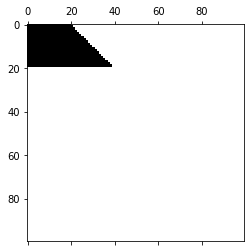

In [19]:
m=100
K=20
M = np.ones((m,m))
M[K:,:] = 0
v=np.arange(m)
M = M * (v[:,None] < (v+K)) * (v[:,None] > (v-K))
plt.spy(M)

<Figure size 720x720 with 0 Axes>

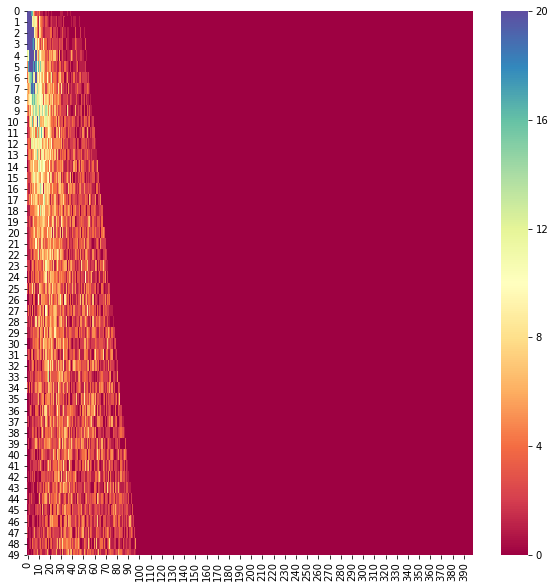

In [20]:
plt.figure(figsize=(10,10))
sns.heatmap(q_nd_dev(q,50), vmax=20, cmap=cmap)

<Figure size 720x720 with 0 Axes>

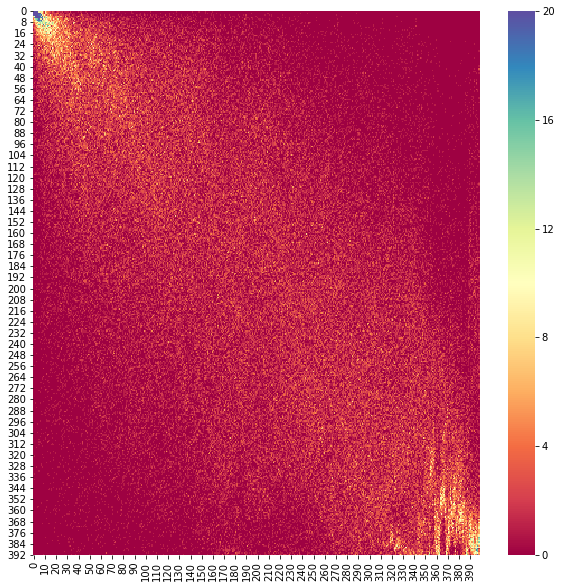

In [21]:
plt.figure(figsize=(10,10))
sns.heatmap(q, vmax=20, cmap=cmap)

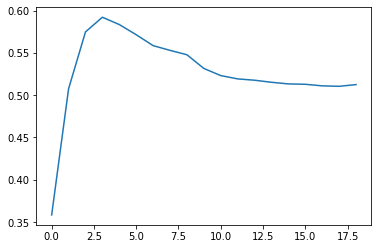

In [22]:
plt.plot([q_nx(q, k) for k in range(1,20)])

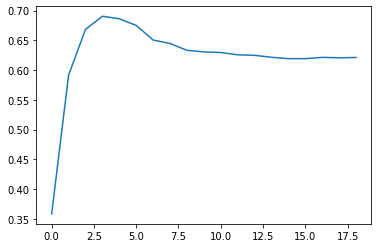

In [23]:
plt.plot([q_nd(q, k) for k in range(1,20)])

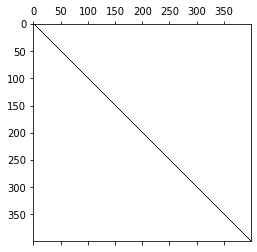

In [42]:
# plt.spy(q)